###  Домашнее задание по теме «Ведение DS-проектов»

### 1. Понимание бизнеса

#### 1.1. Цель
Предсказать качество вина по его физико-химическим характеристикам.

#### 1.2. Описание
Два набора данных относятся к красному и белому вариантам португальского вина «Vinho Verde».
Из соображений конфиденциальности и логистики доступны только физико-химические (входные) и органолептические (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин намного больше, чем отличных или плохих). Алгоритмы обнаружения выбросов можно использовать для определения нескольких отличных или плохих вин. Кроме того, мы не уверены, что все входные переменные релевантны. Так что было бы интересно протестировать методы выбора признаков.

Два набора данных были объединены, и несколько значений были удалены случайным образом.


### 2. Data Understanding

#### 2.1 Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

#### 2.2 Вспомогательные функции

In [11]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

#### 2.3 Загрузка данных

In [5]:
data = pd.read_csv('C:\\Users\\2-hom\\Documents\\Data_analysis\\Работа с заказчиком\\Домашнее задание 2\\winequalityN.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


#### 2.4 Статистика и визуализации

In [6]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Информация об атрибутах:

Входные переменные (на основе физико-химических тестов):
1. - fixed acidity (фиксированная кислотность)
2. - volatile acidity (летучая кислотность)
3. - citric acid (лимонная кислота)
4. - residual sugar (остаточный сахар)
5. - chlorides (хлориды)
6. - free sulfur dioxide (свободный диоксид серы)
7. - total sulfur dioxide (общий диоксид серы)
8. - density (плотность)
9. - рН
10. - sulphates (сульфаты)
11. - alcohol (спирт)

Выходная переменная (на основе сенсорных данных):

12. - quality (качество) (оценка от 0 до 10)

#### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных

Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений.

Обратите особое внимание на тип каждой переменной, количество наблюдений и некоторые значения переменных.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [7]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


#### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

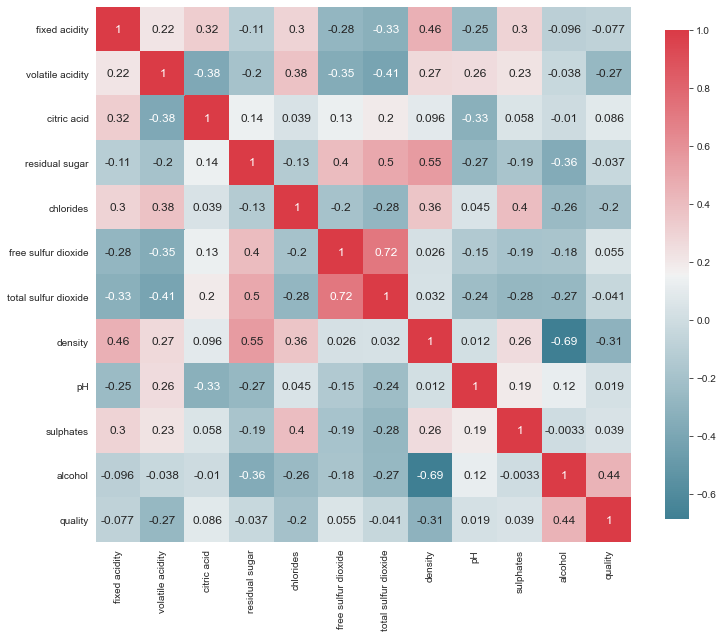

In [12]:
plot_correlation_map( data )

In [24]:
data.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.220172,0.323736,-0.112319,0.298421,-0.283317,-0.329747,0.459204,-0.251814,0.300380,-0.095603,-0.077031
volatile acidity,0.220172,1.000000,-0.378061,-0.196702,0.377167,-0.353230,-0.414928,0.271193,0.260660,0.225476,-0.038248,-0.265953
citric acid,0.323736,-0.378061,1.000000,0.142486,0.039315,0.133437,0.195218,0.096320,-0.328689,0.057613,-0.010433,0.085706
residual sugar,-0.112319,-0.196702,0.142486,1.000000,-0.128902,0.403439,0.495820,0.552498,-0.267050,-0.185745,-0.359706,-0.036825
chlorides,0.298421,0.377167,0.039315,-0.128902,1.000000,-0.195042,-0.279580,0.362594,0.044806,0.395332,-0.256861,-0.200886
free sulfur dioxide,-0.283317,-0.353230,0.133437,0.403439,-0.195042,1.000000,0.720934,0.025717,-0.145191,-0.188489,-0.179838,0.055463
total sulfur dioxide,-0.329747,-0.414928,0.195218,0.495820,-0.279580,0.720934,1.000000,0.032395,-0.237687,-0.275381,-0.265740,-0.041385
density,0.459204,0.271193,0.096320,0.552498,0.362594,0.025717,0.032395,1.000000,0.011920,0.259454,-0.686745,-0.305858
pH,-0.251814,0.260660,-0.328689,-0.267050,0.044806,-0.145191,-0.237687,0.011920,1.000000,0.191248,0.121002,0.019366
sulphates,0.300380,0.225476,0.057613,-0.185745,0.395332,-0.188489,-0.275381,0.259454,0.191248,1.000000,-0.003261,0.038729


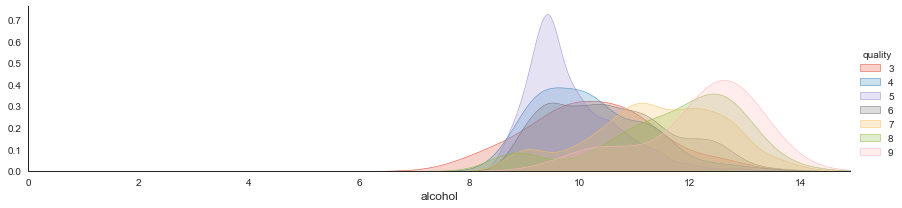

In [15]:
plot_distribution( data , var = 'alcohol' , target = 'quality')

### 3. Data Preparation

#### 3.1 Категориальные переменные должны быть преобразованы в числовые переменные
Некоторые из алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных (OneHotEncoding)/
В нашем датасете категориальных переменных нет, поэтому пропустим данный этап

#### 3.2 Заполнить пропущенные значения в переменных

Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений либо наиболее часто встречающимся значением - модой.

In [33]:
data['fixed acidity'].fillna(data['fixed acidity'].mode()[0], inplace=True)
data['fixed acidity'].value_counts()

6.80     364
6.60     326
6.40     305
7.00     282
6.90     279
        ... 
14.30      1
15.90      1
13.80      1
14.20      1
6.45       1
Name: fixed acidity, Length: 106, dtype: int64

In [26]:
data['volatile acidity'].fillna(data['volatile acidity'].mode()[0], inplace=True)
data['volatile acidity'].value_counts()

0.280    294
0.240    265
0.260    255
0.250    238
0.220    235
        ... 
0.805      1
1.130      1
1.185      1
0.565      1
0.865      1
Name: volatile acidity, Length: 187, dtype: int64

In [27]:
data['citric acid'].fillna(data['citric acid'].mode()[0], inplace=True)
data['citric acid'].value_counts()

0.30    340
0.28    301
0.32    289
0.49    283
0.26    257
       ... 
1.66      1
0.75      1
0.86      1
0.99      1
1.23      1
Name: citric acid, Length: 89, dtype: int64

In [28]:
data['residual sugar'].fillna(data['residual sugar'].mode()[0], inplace=True)
data['residual sugar'].value_counts()

2.00     237
1.80     228
1.60     223
1.40     219
1.20     195
        ... 
14.15      1
14.05      1
3.15       1
8.95       1
20.30      1
Name: residual sugar, Length: 316, dtype: int64

In [29]:
data['chlorides'].fillna(data['chlorides'].mode()[0], inplace=True)
data['chlorides'].value_counts()

0.044    208
0.036    200
0.042    187
0.046    185
0.050    182
        ... 
0.213      1
0.165      1
0.150      1
0.144      1
0.125      1
Name: chlorides, Length: 214, dtype: int64

In [30]:
data['pH'].fillna(data['pH'].mode()[0], inplace=True)
data['pH'].value_counts()

3.16    209
3.14    193
3.22    185
3.20    176
3.19    170
       ... 
3.81      1
2.77      1
2.82      1
2.84      1
3.82      1
Name: pH, Length: 108, dtype: int64

In [31]:
data['sulphates'].fillna(data['sulphates'].mode()[0], inplace=True)
data['sulphates'].value_counts()

0.50    279
0.46    243
0.54    234
0.44    232
0.38    214
       ... 
1.59      1
1.12      1
1.33      1
1.56      1
1.62      1
Name: sulphates, Length: 111, dtype: int64

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


#### 3.3 Feature Engineering – добавляем новые признаки

Так как данные представлены физико-химическими характеристиками, то генироровать новые данные видится излишним. Поэтому пропустим данный этап. 

#### 3.4 Сборка финальных датасетов для моделирования

#### 3.4.1 Variable selection

Выбираем признаки для формирования итогового датасет. У нас доступны признаки:

1. fixed acidity (фиксированная кислотность)
2. volatile acidity (летучая кислотность)
3. citric acid (лимонная кислота)
4. residual sugar (остаточный сахар)
5. chlorides (хлориды)
6. free sulfur dioxide (свободный диоксид серы)
7. total sulfur dioxide (общий диоксид серы)
8. density (плотность)
9. рН
10. sulphates (сульфаты)
11. alcohol (спирт)

In [41]:
data.rename(columns={'fixed acidity': 'fixed_acidity', 'volatile acidity': 'volatile_acidity', 'citric acid':'citric_acid', 'residual sugar':'residual_sugar','free sulfur dioxide':'free_sulfur_dioxide', 'total sulfur dioxide':'total_sulfur_dioxide'},
                     inplace=True)
data.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [46]:
full_X = pd.concat( [ data.fixed_acidity, data.volatile_acidity, data.citric_acid, data.residual_sugar, data.chlorides, data.free_sulfur_dioxide, data.total_sulfur_dioxide, data.density, data.pH, data.sulphates, data.alcohol] , axis=1 )
                  
full_X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [48]:
full_X.shape

(6497, 11)

#### 3.4.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [56]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X, test_X, train_valid_y, test_y = train_test_split(full_X, data.quality, test_size=0.3, random_state=42)
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X, train_valid_y, train_size = .7 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

(6497, 11) (3182, 11) (1365, 11) (3182,) (1365,) (1950, 11)


#### 3.4.3 Важность признаков

Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


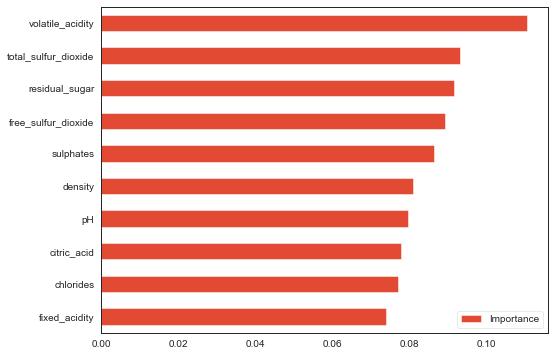

In [57]:
plot_variable_importance(train_X, train_y)

### 4. Моделирование

Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

#### 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия.

In [58]:
model = LogisticRegression()

#### 4.2 Обучение модели

In [59]:
model.fit( train_X , train_y )

LogisticRegression()

### 5. Оценка

Теперь мы собираемся оценить модель

#### 5.1 Модель

Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [60]:
# Score the model
print (model.score( train_X , train_y ) , model.score( test_X , test_y ))

0.4714016341923319 0.46615384615384614


### 6. Развертывание

Развертывание в данном означает направление домашнего задания на проверку